In [2]:
# Import needed Python modules
import geopandas as gp
import numpy as np
import pandas as p
# import xlsxwriter
# import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.ticker import PercentFormatter
# import shapely
import datetime
import folium
import folium.plugins
import scipy.stats
import mapclassify
from xyzservices import TileProvider

LOADING AND PREPROCESSING THE DATA

In [3]:
# Load the Digiroad stop data by ELY Centre area and insert the ELY ID to the data
dr_uudely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\uudely.gpkg")
dr_uudely.insert(0, 'ely', 1)
dr_varely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\varely.gpkg")
dr_varely.insert(0, 'ely', 2)
dr_pirely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\pirely.gpkg")
dr_pirely.insert(0, 'ely', 5)
dr_kasely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\kasely.gpkg")
dr_kasely.insert(0, 'ely', 6)
dr_posely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\posely.gpkg")
dr_posely.insert(0, 'ely', 8)
dr_kesely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\kesely.gpkg")
dr_kesely.insert(0, 'ely', 10)
dr_epoely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\epoely.gpkg")
dr_epoely.insert(0, 'ely', 11)
dr_popely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\popely.gpkg")
dr_popely.insert(0, 'ely', 13)
dr_lapely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Graduaineistot_DR\lapely.gpkg")
dr_lapely.insert(0, 'ely', 15)

# Create a list of the DR stop data by county
dr_stops_list = [dr_uudely, dr_varely, dr_pirely, dr_kasely, dr_posely, dr_kesely, dr_epoely, dr_popely, dr_lapely]

# Create a function to replace missing values in data
def replaceWithNan(dr_stops_list):
    return dr_stops_list.infer_objects(copy=False).replace(r'^\s*$', np.nan, regex=True)
# Use the function to replace missing values with NaN
dr_stops_list = [replaceWithNan(dr_stops_list) for dr_stops_list in dr_stops_list]

# Merge the separated DR stop data to a single GeoDataFrame
dr_stops_all = p.concat([dr_stops_list[0], dr_stops_list[1], dr_stops_list[2], dr_stops_list[3], dr_stops_list[4], dr_stops_list[5], dr_stops_list[6],
                            dr_stops_list[7], dr_stops_list[8]], ignore_index=True)

# Replace 99 values with Nan
for i in range(len(dr_stops_all)):
    if dr_stops_all.at[i,'aikataulu'] == 99:
        dr_stops_all.at[i,'aikataulu'] = np.nan
    if dr_stops_all.at[i,'penkki'] == 99:
        dr_stops_all.at[i,'penkki'] = np.nan
    if dr_stops_all.at[i,'katos'] == 99:
        dr_stops_all.at[i,'katos'] = np.nan
    if dr_stops_all.at[i,'s_aikataul'] == 99:
        dr_stops_all.at[i,'s_aikataul'] = np.nan
    if dr_stops_all.at[i,'korotettu'] == 99:
        dr_stops_all.at[i,'korotettu'] = np.nan
    if dr_stops_all.at[i,'pyoratelin'] == 99:
        dr_stops_all.at[i,'pyoratelin'] = np.nan
    if dr_stops_all.at[i,'mainoskat'] == 99:
        dr_stops_all.at[i,'mainoskat'] = np.nan
    if dr_stops_all.at[i,'saattomahd'] == 99:
        dr_stops_all.at[i,'saattomahd'] = np.nan
    if dr_stops_all.at[i,'valaistus'] == 99:
        dr_stops_all.at[i,'valaistus'] = np.nan
    if dr_stops_all.at[i,'yllapitaja'] == 99:
        dr_stops_all.at[i,'yllapitaja'] = np.nan
    if dr_stops_all.at[i,'pys_tyyppi'] == 99:
        dr_stops_all.at[i,'pys_tyyppi'] = np.nan

C:\Users\Jenni Autere\AppData\Local\Temp\ipykernel_10448\1790889869.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return dr_stops_list.infer_objects(copy=False).replace(r'^\s*$', np.nan, regex=True)


In [4]:
# Load municipality (mun) and ELY Centre (ely) polygon data. These dataframes will host the quality information.
ely_QI = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Taustaaineistot\elyalueet2023.gpkg")
municipality_QI = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\Taustaaineistot\kuntajako2023.gpkg")
# Sort ELY polygon data to be in order by ELY Id
ely_QI = ely_QI.sort_values(by='ely', ascending=True, ignore_index=True)
# Convert ELY and municipality Id numbers to int64
ely_QI = ely_QI.astype({'ely':'int64'})
municipality_QI = municipality_QI.astype({'kunta':'int64'})

# Add ELY Centre name abbreviations to the ELY polygon data
ely_id = ['UUDELY', 'VARELY', 'PIRELY', 'KASELY', 'POSELY', 'KESELY', 'EPOELY', 'POPELY', 'LAPELY']
ely_QI['lyhenne'] = "" # Create empty column for abbreviation
i = 0
while i < len(ely_QI):
    ely_QI.iloc[i,6] = ely_id[i]
    i += 1

# Add ELY Centre name abbreviations to municipality polygon data
#municipality_QI_temp = municipality_QI
municipality_QI['ely'] = "" # Create empty column for abbreviation

i = 0
while i < len(ely_QI):
    geometry = ely_QI.geometry[i] # Select a ELY geometry
    k = 0
    while k < len(municipality_QI):
        if municipality_QI.iloc[k,5].within(geometry):
            municipality_QI.iloc[k,6] = ely_QI.iloc[i,6] # Add ELY abbreaviation if municipality geometry within ELY geometry
        k += 1
    i += 1

# Calculate the number of bus stops in a munincipality 
stop_count = dr_stops_all.groupby('kuntakoodi').size()
stop_count = stop_count.reset_index()
stop_count.rename(columns={0:'pysakkien_maara','kuntakoodi':'kunta'}, inplace=True)
municipality_QI = municipality_QI.merge(stop_count, how='outer', on=['kunta'])

# Create a list of the munincipal codes in DR stop data and sort it
municipal_id_dr = dr_stops_all.kuntakoodi.unique()
municipal_id_dr.sort()

In [5]:
# Load OSM stop data separated by ELY Centre area
osm_uudely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_uudely.gpkg")
osm_varely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_varely.gpkg")
osm_pirely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_pirely.gpkg")
osm_kasely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_kasely.gpkg")
osm_posely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_posely.gpkg")
osm_kesely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_kesely.gpkg")
osm_epoely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_epoely.gpkg")
osm_popely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_popely.gpkg")
osm_lapely = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\osm_lapely.gpkg")

# Create list from OSM geodataframes
osm_stops_list = [osm_uudely, osm_varely, osm_pirely, osm_kasely, osm_posely, osm_kesely, osm_epoely, osm_popely, osm_lapely]

# Load the OSM data including all stops in Finland
osm_stops_all = gp.read_file(r"C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\OSM-aineistot\kokosuomi.gpkg")

In [6]:
# OSM data doesn't have munincipal Id numbers, so they need to be added to the dataframes

# Create new dataframe for OSM stops with munincipal Id
osmStops_munId = p.DataFrame(columns = ['full_id', 'osm_id', 'osm_type', 'highway', 'ref:findr', 'name:sv', 'name:fi', 'name', 'geometry', 'kunta'])
municipal_id_int = municipality_QI.kunta.unique() # Save munincipal Id numbers from polygon data to a variable

i = 0
while i < len(municipal_id_dr):
    geometry = municipality_QI.geometry[i] # Select municipality geometry
    osmSubset = osm_stops_all[osm_stops_all.within(geometry)] # Create subset from OSM stops by municipality geometry
    osmSubset.loc[slice(None), 'kunta'] = str(municipality_QI.iloc[i,0]) # Add municipality Id from geometry
    osmStops_munId = p.concat([osmStops_munId, osmSubset], axis=0, ignore_index=True, copy=False) # Add OSM stops to the new dataframe
    i = i + 1

# Some OSM stops are outside of municipality geometries, so they need to have municipality Id numbers added manually
# Create a new column for municipality Id to the original OSM dataframe
osm_stops_all['kunta'] = np.nan

# Add missing munincipal Id numbers to stops
missingStops_espoo = ['60761224', '1398792779', '6092621568']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_espoo), 'kunta'] = '49'
missingStops_helsinki = ['370307691', '408775467', '475714793', '475714796', '488284845', '3050055694', '7008571115', '11037074729']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_helsinki), 'kunta'] = '91'
missingStops_pori = ['897518664', '897518931', '6271081682', '6271081683']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_pori), 'kunta'] = '609'
missingStops_parainen = ['2764596229', '2961579645', '2961579646', '6259556851', '6259556852', '9766537877']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_parainen), 'kunta'] = '445'
missingStops_oulu = ['1815107856', '10790734838']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_oulu), 'kunta'] = '564'
missingStops_naantali = ['6259555671', '6259555680', '6259556238']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_naantali), 'kunta'] = '529'
missingStops_turku = ['6090192118', '6090192158']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_turku), 'kunta'] = '853'
missingStops_kaarina = ['6259558401', '6259561483']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_kaarina), 'kunta'] = '202'
missingStops_kotka = ['6270886981', '6270887644']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_kotka), 'kunta'] = '285'
missingStops_voyri = ['6270969691', '6270969726']
osm_stops_all.loc[osm_stops_all['osm_id'].isin(missingStops_voyri), 'kunta'] = '946'
osm_stops_all.loc[osm_stops_all['osm_id'] == '6271025210', 'kunta'] = '72' # Hailuoto
osm_stops_all.loc[osm_stops_all['osm_id'] == '6270971243', 'kunta'] = '440' # Luoto
osm_stops_all.loc[osm_stops_all['osm_id'] == '6259556831', 'kunta'] = '304' # Kustavi
osm_stops_all.loc[osm_stops_all['osm_id'] == '6111500407', 'kunta'] = '734' # Salo
osm_stops_all.loc[osm_stops_all['osm_id'] == '4859616741', 'kunta'] = '272' # Kokkola
osm_stops_all.loc[osm_stops_all['osm_id'] == '4927890428', 'kunta'] = '149' # Inkoo

# Add the manually filled stops to the dataframe
osmStops_munId = p.concat([osmStops_munId, osm_stops_all[osm_stops_all['kunta'].notna()]], axis = 0, ignore_index=True, copy=False)

# Check that all OSM stops have a munincipal Id
print(osmStops_munId['kunta'].isna().sum())

# Convert column type to integer
osmStops_munId['kunta'] = osmStops_munId['kunta'].astype('int64')

c:\Users\Jenni Autere\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Jenni Autere\AppData\Local\Temp\ipykernel_10448\3207986095.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  osmStops_munId = p.concat([osmStops_munId, osmSubset], axis=0, ignore_index=True, copy=False) # Add OSM stops to the new dataframe
c:\Users\Jenni Autere\AppData\Local\Programs\Python\Python312\Li

0


ATTRIBUTE COMPLETENESS

In [7]:
# Calculate attribute completeness for every DR bus stop
attrCompletenessList = []
i = 0
while i < len(dr_stops_all):
    completeness = 100 - dr_stops_all.iloc[i].isna().sum().sum() / len(dr_stops_all.columns) * 100 # Count the completeness value
    attrCompletenessList.append(completeness) # Add to the empty list
    i = i + 1
# Insert the list filled with completeness values to the stop data
dr_stops_all.insert(0, 'sisällöllinenTäydellisyys', attrCompletenessList) 

In [8]:
# Calculate attribute completeness for ELY Centre areas from DR stop data
elyCompletenessList = []
elyId = ely_QI.ely.unique() # Save ELY Id number as a variable 'elyId'

i = 0
while i < len(dr_stops_list):
  elySubset = dr_stops_all.loc[dr_stops_all['ely'] == elyId[i]] # Select stops by ELY Id
  completeness = elySubset['sisällöllinenTäydellisyys'].mean() # Calculate mean complenetess for ELY area
  elyCompletenessList.append(completeness) # Add to list
  i = i + 1

# Add mean completeness values to ELY polygon data
ely_QI.insert(0, 'sisällöllinenTäydellisyys', elyCompletenessList)

In [9]:
# Calculate mean attribute completeness for munincipalities
municipalCompletenessList = []
i = 0
while i < len(municipal_id_dr):
    municipalSubset = dr_stops_all.loc[dr_stops_all['kuntakoodi'] == municipal_id_dr[i]]
    completeness = municipalSubset['sisällöllinenTäydellisyys'].mean()
    municipalCompletenessList.append(completeness)
    i = i + 1

# Sort the municipality polygon data by munincipal Id
municipality_QI.sort_values(by=['kunta'])

# Create new dataframe from munincipal attribute completeness and municipality Id
municipalCompletenessList_df = p.DataFrame(list(zip(municipal_id_dr, municipalCompletenessList)), columns =['kunta', 'sisällöllinenTäydellisyys'])
# Convert municipality Id to integer in the polygon data
municipality_QI['kunta'] = municipality_QI['kunta'].astype('int64')
# Merge attribute completeness dataframe to municipality polygon data by municipality Id
municipality_QI = municipality_QI.merge(municipalCompletenessList_df, how='outer', on=['kunta'])

In [27]:
# Calculate attribute completeness
noNanCells = dr_stops_all.count(axis=0) # Count no-NA cells
attributeCompleteness_df = p.DataFrame(data={'noNanCellsCount':noNanCells}) # Create dataframe for attribute completeness
attributeCompleteness_df = attributeCompleteness_df.reset_index() # Reset index to move attribute names into column
attributeCompleteness_df = attributeCompleteness_df.rename(columns={'index':'attribute'}) # Rename attribute names columns
attributeCompleteness_df['completeness'] = 0.0 # Create empty column for completeness values

for i in range(len(attributeCompleteness_df)):
    completeness = attributeCompleteness_df.at[i,'noNanCellsCount'] / len(dr_stops_all) * 100
    attributeCompleteness_df.at[i,'completeness'] = completeness

attributeCompleteness_df = attributeCompleteness_df.round({'completeness':2}) # Round completeness to 2 decimals
attributeCompleteness_df.head(50)

,attribute,noNanCellsCount,completeness
0,sisällöllinenTäydellisyys,94119,100.00
1,ely,94119,100.00
2,valtak_id,94119,100.00
3,sijainti_m,94119,100.00
4,vaik_suunt,94119,100.00
5,nimi_su,93774,99.63
6,nimi_ru,25644,27.25
7,yllapitaja,94069,99.95
8,yllap_tunnus,26736,28.41
9,livi_tunn,64462,68.49


TIMELINESS

In [ ]:
# Create empty list for stop timeliness information
stopTimeliness = []
# Set current datetime
#currentDate = p.to_datetime('today').normalize()
currentDate = '2024-03-15 00:00:00'
currentDate = p.Timestamp(ts_input=currentDate)

# Calculate timeliness for stops
i = 0
while i < len(dr_stops_all):
    stopSubset = dr_stops_all['muokkauspv'][i] # Select stop modifying time
    stopSubset_date = datetime.datetime.strptime(stopSubset, "%d.%m.%Y %H:%M:%S") # Convert datetime
    stopSubset_difference = (currentDate - stopSubset_date).days / 365 # Convert to years
    stopTimeliness.append(stopSubset_difference) # Add to list
    i = i + 1
# Insert timeliness values to DR stop data
dr_stops_all.insert(0, 'ajankohtaisuus', stopTimeliness)

In [ ]:
# Calculate mean timeliness values for munincipalities
munTimeliness = []
i = 0
while i < len(municipal_id_dr):
    municipalSubset = dr_stops_all.loc[dr_stops_all['kuntakoodi'] == municipal_id_dr[i]]
    munTimelinessMean = municipalSubset['ajankohtaisuus'].mean()
    munTimeliness.append(munTimelinessMean)
    i = i + 1
# Create dataframe from timeliness values and municipality Id
munTimeliness_df = p.DataFrame(list(zip(municipal_id_dr, munTimeliness)), columns =['kunta', 'ajankohtaisuus'])
# Merge timeliness values to municipality polygon data by munincipalit Id
municipality_QI = municipality_QI.merge(munTimeliness_df, how='outer', on=['kunta'])

In [ ]:
# Calculate mean timeliness values for ELY area
elyTimeliness = []
i = 0
while i < len(dr_stops_list):
    elySubset = dr_stops_all.loc[dr_stops_all['ely'] == elyId[i]]
    elyTimelinessMean = elySubset['ajankohtaisuus'].mean()
    elyTimeliness.append(elyTimelinessMean)
    i = i + 1
# Add mean timeliness to ELY polygon data
ely_QI.insert(0, 'ajankohtaisuus', elyTimeliness)

DATA COMPLETENESS

In [ ]:
# Calculate data completeness for munincipalities into a empty list
municipalDataCompleteness_list = []
municipal_id_osm = osmStops_munId.kunta.unique() # Save municipality Id numbers from OSM data into a variable
i = 0
while i < len(municipal_id_osm):
    municipalSubset_dr = dr_stops_all.loc[dr_stops_all['kuntakoodi'] == municipal_id_dr[i]] # Subset DR stops by municipality Id
    municipalSubset_osm = osmStops_munId.loc[osmStops_munId['kunta'] == municipal_id_osm[i]]# Subset OSM stops by municipality Id
    completeness = len(municipalSubset_dr) / len(municipalSubset_osm) * 100 # Calculate spatial completeness
    municipalDataCompleteness_list.append(completeness)
    i = i + 1
###Luodaan tyhjä taulukko alueelliselle täydellisyydelle kunnittain
municipalDataCompleteness_df = p.DataFrame(list(zip(municipal_id_dr, municipalDataCompleteness_list)), columns =['kunta', 'alueellinenTäydellisyys'])
###Lisätään luvut kunta-aineistoon
municipality_QI = municipality_QI.merge(municipalDataCompleteness_df, how='outer', on=['kunta'])

In [ ]:
# Calculate mean data completeness values for ELY regions
elyDataCompleteness = []
i = 0
while i < len(ely_QI):
    geometry = ely_QI.geometry[i] # Select geometry of Ely region
    elyRegionMunincipalities = municipality_QI[municipality_QI.within(geometry)] # Select mean data completeness values of munincipalities in ELY region
    completeness = elyRegionMunincipalities['alueellinenTäydellisyys'].mean() # Calculate mean data completeness for ELY region
    elyDataCompleteness.append(completeness) # Append to a list
    i = i + 1
# Insert data completeness values in ELY regions to the ELY quality information data
ely_QI.insert(0, 'alueellinenTäydellisyys', elyDataCompleteness)

POSITIONAL ACCURACY

In [ ]:
# In order to asses positional accuracy, the DR and OSM stops need to be data matched
# Rename some od the column in order to match the column names in both dataframes
osmStops_munId.rename(columns = {'ref:findr':'valtak_id'}, inplace=True)
# Change national stop id to a string in both dataframes
osmStops_munId = osmStops_munId.astype({'valtak_id':'str'})
dr_stops_all = dr_stops_all.astype({'valtak_id':'str'})
# Create subsets of both dataframes to remove unnecessary columns
dr_stops_all_subset = dr_stops_all.loc[:,['valtak_id', 'nimi_su', 'nimi_ru', 'yllapitaja', 'kuntakoodi', 'geometry']].copy()
osm_stops_all_subset = osmStops_munId.loc[:,['valtak_id', 'name:sv', 'name:fi', 'kunta', 'geometry']].copy()
# Perform a join based on the national stop id number. Not all OSM stops have this information, so the new dataframe will have less features than the original DR dataframe.
dr_osm_merged = p.merge(dr_stops_all_subset, osm_stops_all_subset, on=['valtak_id'], suffixes=(None, '_osm'))

In [ ]:
# Calculate the relative distance between matched stops
distances = []
i = 0
while i < len(dr_osm_merged):
    dr_coordinates = dr_osm_merged.iloc[i,5]
    osm_coordinates = dr_osm_merged.iloc[i,9]
    distance = dr_coordinates.distance(osm_coordinates)
    distances.append(distance)
    i = i + 1
# Insert distance values (metres) into the dataframe
dr_osm_merged.insert(0, 'sijaintitarkkuus_m', distances)

In [ ]:
# Sort merged stop data by municipality id
dr_osm_merged.sort_values('kuntakoodi', inplace=True)

# Calculate positional accuracty for stops in munincipalities
munPositionalAccuracy = []
i = 0
while i < len(municipal_id_dr):
    munincipalSubset = dr_osm_merged.loc[dr_osm_merged['kuntakoodi'] == municipal_id_dr[i]] # Create subset of bus stops in municipality
    distanceOver30m = munincipalSubset.loc[munincipalSubset['sijaintitarkkuus_m'] > 30] # Create another subset of the municipality's bus stops that have over 30 m distance between DR and OSM datasets
    positionalAccuracy = 100 - len(distanceOver30m) / len(munincipalSubset) * 100 # Calculate the percent of positionally accurate stops (distance under 30 m) in the municipality
    munPositionalAccuracy.append(positionalAccuracy) # Append to list
    i = i + 1

# Insert positional accuracy values in to the municipality qualtiy information data
municipality_QI.insert(0, 'sijaintitarkkuus', munPositionalAccuracy)

In [ ]:
# Calculate mean positional accuracy values for ELY regions
elyPositionalAccuracy = []
i = 0
while i < len(ely_QI):
    geometry = ely_QI.geometry[i]
    positionalAccuracySubSet = municipality_QI[municipality_QI.within(geometry)] # Create a subset of the munincipalities' positional accuracy in ELY region
    elyPositionalAccuracyMean = positionalAccuracySubSet['sijaintitarkkuus'].mean() # Calculate mean
    elyPositionalAccuracy.append(elyPositionalAccuracyMean) # Append mean positinal accuracy to list
    i = i + 1
ely_QI.insert(0, 'sijaintitarkkuus', elyPositionalAccuracy)

EXPORTING THE QUALITY INFORMATION

In [ ]:
ely_QI.to_excel(r'C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\IPY-kirjastot\gradu_loppuaineisto_elyt.xlsx', engine='xlsxwriter')
municipality_QI.to_excel(r'C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\IPY-kirjastot\gradu_loppuaineisto_kunnat.xlsx', engine='xlsxwriter')

VISUALIZATION

In [ ]:
# Calculate Kendall's tau correlation coefficient between quality indicators in municipalities
DC_AC = scipy.stats.kendalltau(municipality_QI['alueellinenTäydellisyys'], municipality_QI['sisällöllinenTäydellisyys'])
DC_TI = scipy.stats.kendalltau(municipality_QI['alueellinenTäydellisyys'], municipality_QI['ajankohtaisuus'])
DC_PA = scipy.stats.kendalltau(municipality_QI['alueellinenTäydellisyys'], municipality_QI['sijaintitarkkuus'])
AC_TI = scipy.stats.kendalltau(municipality_QI['sisällöllinenTäydellisyys'], municipality_QI['ajankohtaisuus'])
AC_PA = scipy.stats.kendalltau(municipality_QI['sisällöllinenTäydellisyys'], municipality_QI['sijaintitarkkuus'])
TI_PA = scipy.stats.kendalltau(municipality_QI['ajankohtaisuus'], municipality_QI['sijaintitarkkuus'])

# Calculate Kendall's tau correlation coefficient between quality indicators and the bus stop count in municipalities
DC_BC = scipy.stats.kendalltau(municipality_QI['alueellinenTäydellisyys'], municipality_QI['pysakkien_maara'])
AC_BC = scipy.stats.kendalltau(municipality_QI['sisällöllinenTäydellisyys'], municipality_QI['pysakkien_maara'])
TI_BC = scipy.stats.kendalltau(municipality_QI['ajankohtaisuus'], municipality_QI['pysakkien_maara'])
PA_BC = scipy.stats.kendalltau(municipality_QI['sijaintitarkkuus'], municipality_QI['pysakkien_maara'])

print('The Kendalls Tau between data and attribute completeness is:', DC_AC)
print('The Kendalls Tau between data completeness and timeliness is:', {DC_TI})
print('The Kendalls Tau between data completeness and positional accuracy is:', {DC_PA})
print('The Kendalls Tau between attribute completeness and timeliness is:', {AC_TI})
print('The Kendalls Tau between attribute completeness and positional accuracy is:', {AC_PA})
print('The Kendalls Tau between timeliness and positional accuracy is:', {TI_PA})
print('The Kendalls Tau between data completeness and bus stop count is:', {DC_BC})
print('The Kendalls Tau between attribute completeness and bus stop count is:', {AC_BC})
print('The Kendalls Tau between timeliness and bus stop count is:', {TI_BC})
print('The Kendalls Tau between positional accuracy and bus stop count is:', {PA_BC})


The Kendalls Tau between data and attribute completeness is: SignificanceResult(statistic=0.08450217454042473, pvalue=0.03318634777329471)
The Kendalls Tau between data completeness and timeliness is: {SignificanceResult(statistic=-0.017113863966380025, pvalue=0.6662149044323948)}
The Kendalls Tau between data completeness and positional accuracy is: {SignificanceResult(statistic=0.09238324884809539, pvalue=0.021031162070024728)}
The Kendalls Tau between attribute completeness and timeliness is: {SignificanceResult(statistic=0.0769797206527951, pvalue=0.0494422437708897)}
The Kendalls Tau between attribute completeness and positional accuracy is: {SignificanceResult(statistic=0.13100656275323416, pvalue=0.0009215049082378883)}
The Kendalls Tau between timeliness and positional accuracy is: {SignificanceResult(statistic=-0.017388584885289816, pvalue=0.6600803420250824)}
The Kendalls Tau between data completeness and bus stop count is: {SignificanceResult(statistic=-0.03020096238571728, 

In [ ]:
# Aggregate statistics for quality indicators in munincipalities
municipality_QI.agg(
    {
        "sisällöllinenTäydellisyys": ["min", "max", "mean", "median", "skew", "kurt", "std"],
        "alueellinenTäydellisyys": ["min", "max", "mean", "median", "skew", "kurt", "std"],
        "ajankohtaisuus": ["min", "max", "mean", "median", "skew", "kurt", "std"],
        "sijaintitarkkuus": ["min", "max", "mean", "median", "skew", "kurt", "std"],
    }
)

,sisällöllinenTäydellisyys,alueellinenTäydellisyys,ajankohtaisuus,sijaintitarkkuus
min,58.503743,80.000000,0.974825,75.000000
max,71.753131,127.388535,7.823815,100.000000
mean,64.951540,100.078559,4.131863,96.960147
median,65.206710,100.000000,4.479766,98.263027
skew,-0.282673,2.103985,-0.047220,-2.568047
kurt,-0.076115,17.296015,-1.652184,10.153751
std,2.380150,3.970402,2.279185,3.505470


Text(0.5, 1.0, '')

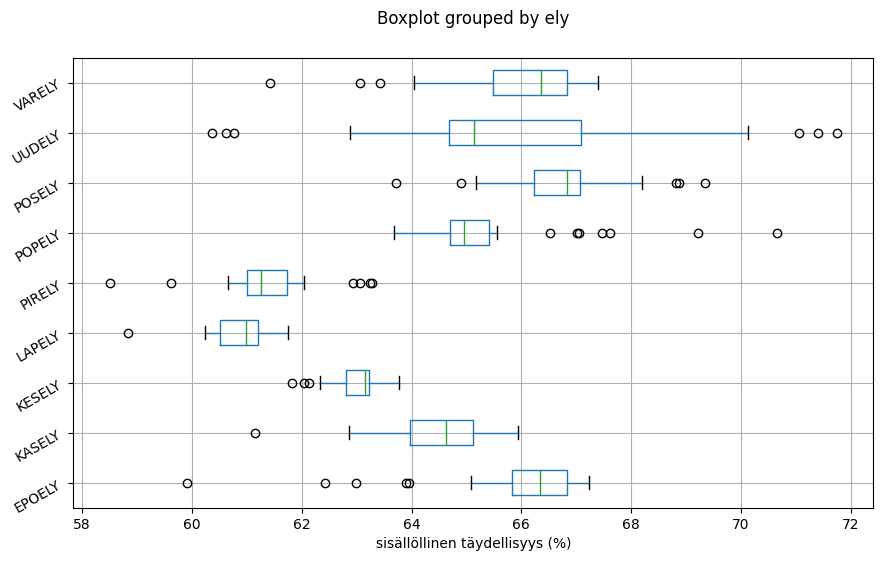

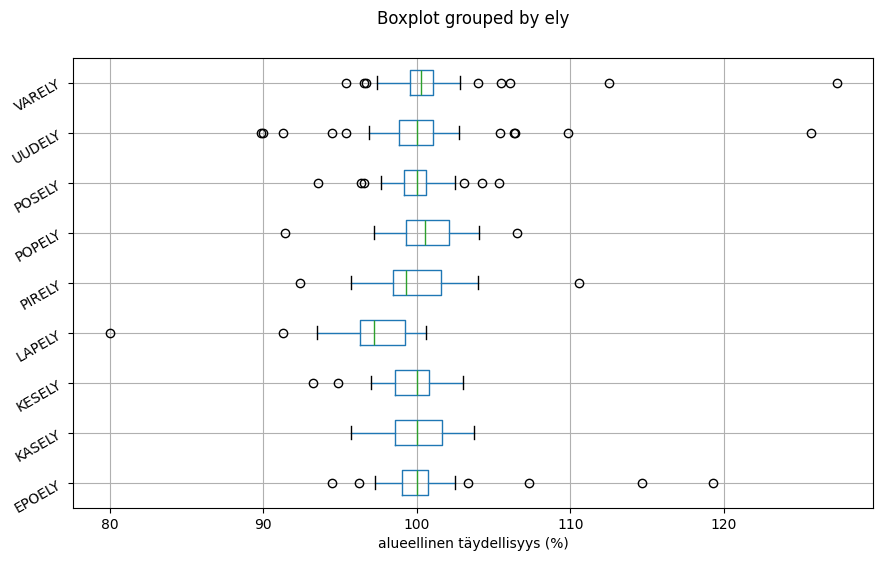

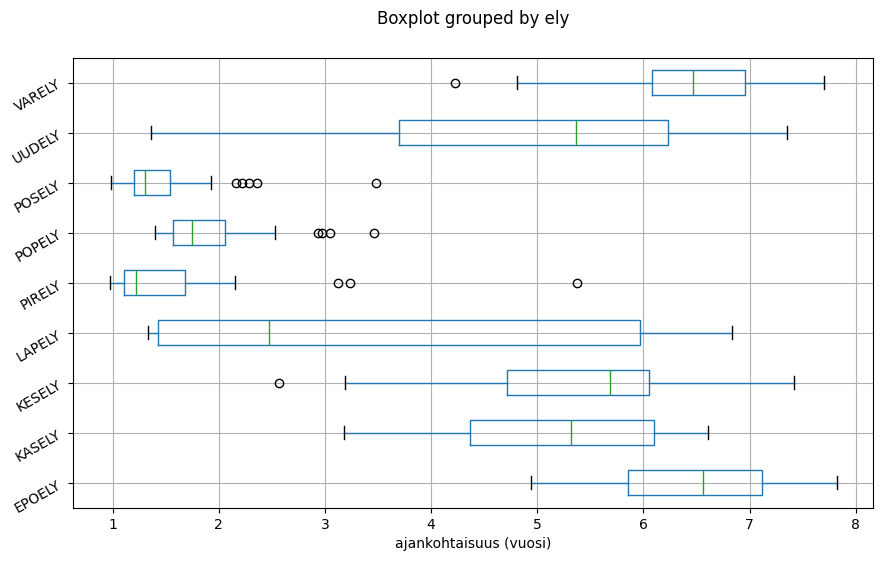

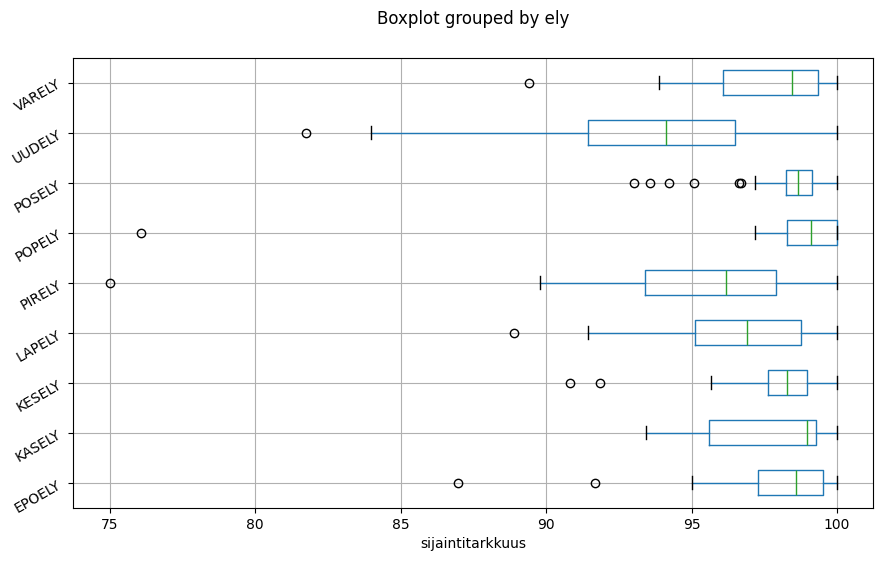

In [ ]:
# Create box plots by ELY regions and set axis labels and title
bp1 = municipality_QI.boxplot(column=['sisällöllinenTäydellisyys'], by="ely", figsize=[10,6], rot=30, vert=False) 
bp1.set_xlabel('sisällöllinen täydellisyys (%)') 
bp1.set_ylabel('')
bp1.set_title('')
bp2 = municipality_QI.boxplot(column=['alueellinenTäydellisyys'], by="ely", figsize=[10,6], rot=30, vert=False) 
bp2.set_xlabel('alueellinen täydellisyys (%)')
bp2.set_ylabel('')
bp2.set_title('')
bp3 = municipality_QI.boxplot(column=['ajankohtaisuus'], by="ely", figsize=[10,6], rot=30, vert=False) 
bp3.set_xlabel('ajankohtaisuus (vuosi)')
bp3.set_ylabel('')
bp3.set_title('')
bp4 = municipality_QI.boxplot(column=['sijaintitarkkuus'], by="ely", figsize=[10,6], rot=30, vert=False) 
bp4.set_xlabel('sijaintitarkkuus')
bp4.set_ylabel('')
bp4.set_title('')


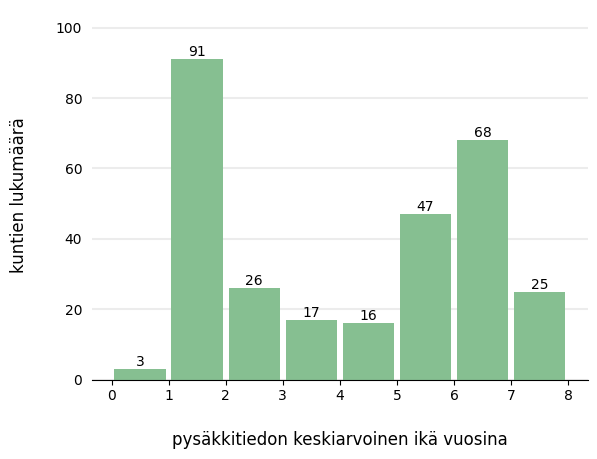

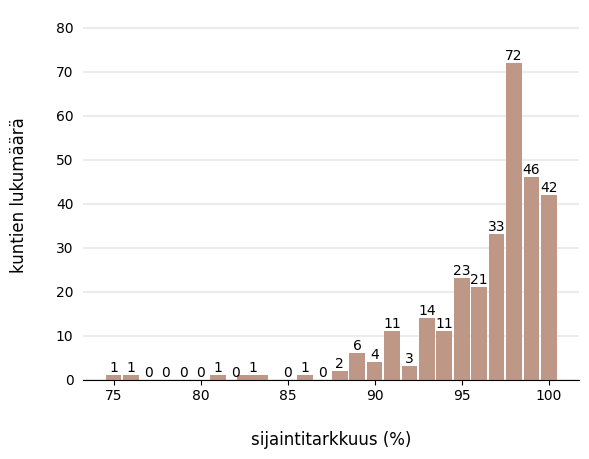

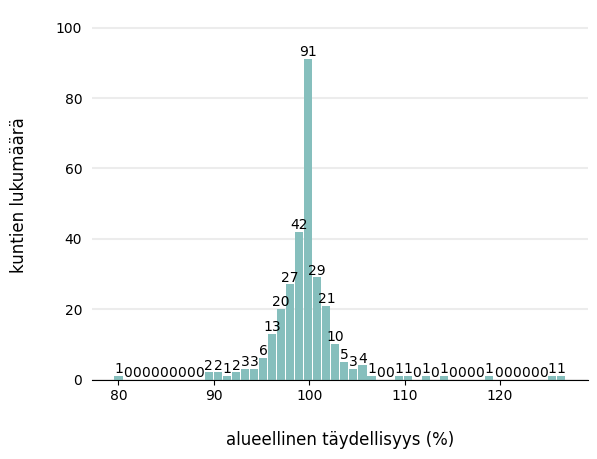

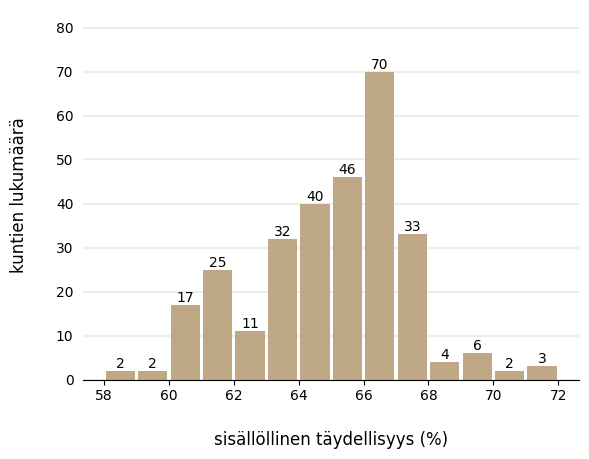

In [ ]:
# Create histograms of quality indicators in municipalities
ax = municipality_QI.hist(column='ajankohtaisuus', 
                          bins=[0,1,2,3,4,5,6,7,8], # Set bins
                          rwidth=0.9, # Bar witdh
                          color='#86bf91', # Bar color
                          grid=False, # Hide grid
                          zorder=2) # Set bars to be in front of horizontal axis lines 
bx = municipality_QI.hist(column='sijaintitarkkuus', 
                          bins=[75,76,77,78,79,80,81,82,83,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101], # Set bins¨
                          align = 'left',
                          rwidth=0.9, 
                          color='#bf9786', 
                          grid=False, 
                          zorder=2)
cx = municipality_QI.hist(column='alueellinenTäydellisyys', 
                          bins=50,
                          rwidth=0.9,
                          align='left',
                          color='#86bfbd',
                          grid=False,zorder=2)
dx = municipality_QI.hist(column='sisällöllinenTäydellisyys', 
                          bins=[58,59,60,61,62,63,64,65,66,67,68,69,70,71,72],
                          rwidth=0.9,
                          color='#bfa886',
                          grid=False,zorder=2)

# Additional formatting and parameters for hidtograms
ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", top=False, left=False, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, alpha=0.4, color='#d1d1d1', zorder=1)

    # Show values
    for p in x.containers:
        x.bar_label(p, label_type='edge')

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("pysäkkitiedon keskiarvoinen ikä vuosina", labelpad=20, size=12)

    # Set y-axis label
    x.set_ylabel("kuntien lukumäärä", labelpad=20, size=12)
bx = bx[0]
for x in bx:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", top=False, left=False, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, alpha=0.4, color='#d1d1d1', zorder=1)

    # Show values
    for p in x.containers:
        x.bar_label(p, label_type='edge')

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("sijaintitarkkuus (%)", labelpad=20, size=12)

    # Set y-axis label
    x.set_ylabel("kuntien lukumäärä", labelpad=20, size=12)

cx = cx[0]
for x in cx:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", top=False, left=False, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, alpha=0.4, color='#d1d1d1', zorder=1)

    # Show values
    ##x.bar_label(x.containers[0])
    for p in x.containers:
        x.bar_label(p, label_type='edge')

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("alueellinen täydellisyys (%)", labelpad=20, size=12)

    # Set y-axis label
    x.set_ylabel("kuntien lukumäärä", labelpad=20, size=12)

dx = dx[0]
for x in dx:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", top=False, left=False, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, alpha=0.4, color='#d1d1d1', zorder=1)

    # Show values
    for p in x.containers:
        x.bar_label(p, label_type='edge')

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("sisällöllinen täydellisyys (%)", labelpad=20, size=12)

    # Set y-axis label
    x.set_ylabel("kuntien lukumäärä", labelpad=20, size=12)

MAP VISUALIZATION

In [ ]:
# Import base map as raster tiles from the National Land Survey of Finland. See README for more information.
mml_basemap = TileProvider(
    name="Maanmittauslaitoksen taustakartta",
    url="https://avoin-karttakuva.maanmittauslaitos.fi/avoin/wmts/1.0.0/taustakartta/default/WGS84_Pseudo-Mercator/{z}/{y}/{x}.png?api-key=c506db28-9e2f-4415-98f1-e4b4241e86e9",
    attribution="Maanmittauslaitos CC BY 4.0"
)

In [ ]:
# Create a Folium map object
m = municipality_QI.explore(
    column="ajankohtaisuus",  # Data (column) being visualized
    cmap = "Blues_r", # Colourmap
    scheme="userdefined",  # määritä luokitteluperuste
    classification_kwds=dict(bins=[1,2,3,4,5,6,7,8]),
    legend=True,  # piirrä selite
    tiles=None, # Hide defaul base map tiles
    zoom_start=5, # Set zoom start
    tooltip=False, # Hide tooltip
    popup=["nimi", "ajankohtaisuus"],  # Show popup (on-click)
    legend_kwds=dict(colorbar=False,caption="Ajankohtaisuus (vuosi)",labels=['0-0,99','1-1,99','2-2,99','3-3,99','4-4,99','5-5,99','6-6,99','7-7,99','8-8,99']),  # Set colorbar caption and labels
    style_kwds=dict(stroke=True, color='grey',weight=0.5, fillOpacity=0.9), # Add stroke and add fill opacity
    name="Ajankohtaisuus, kunnat",  # Name of the layer in the map
)

# Create other layers to be passed to the map object
municipality_QI.explore(
    m=m,  # Pass the map object
    column="sijaintitarkkuus",  # Data (column) being visualized
    scheme="userdefined",  # use mapclassify's natural breaks scheme
    classification_kwds=dict(bins=[80,85,90,95,99.99,100]),
    legend=True,  # show legend
    show=False, # Hide layer on start
    cmap = "Blues", # Colourmap
    tooltip=False,  # Hide tooltip
    popup=["nimi", "sijaintitarkkuus"],  # Show popup (on-click)
    legend_kwds=dict(colorbar=False,caption="Sijaintitarkkuus (%)",labels=['80-84,99','85-89,99','90-94,99','95-99,99','100,00']),  # Set colorbar caption
    style_kwds=dict(stroke=True, color='grey', weight=0.5, fillOpacity=0.9), # Add stroke and add fill opacity
    name="Sijaintitarkkuus, kunnat",  # Name of the layer in the map
)

# Create the rest of the layers as the one above
municipality_QI.explore(
    m=m,  
    column="alueellinenTäydellisyys",  
    show=False,
    scheme="userdefined",  # use mapclassify's natural breaks scheme
    classification_kwds=dict(bins=[89.99,99.99,100.1,109.99,119.99,130]),
    legend=True,  # show legend
    cmap = "RdBu_r", # Use diverging colormap for visualizing data completeness
    tiles=None,
    tooltip=False,  
    popup=["nimi", "alueellinenTäydellisyys"],  
    legend_kwds=dict(colorbar=False,caption="Alueellinen täydellisyys (%)", labels=['80-89,99','90-99,99','100,00','100,01-109,99','110-119,99','120-129,99']),  
    style_kwds=dict(stroke=True, color='grey',weight=0.5,fillOpacity=0.9),
    name="Alueellinen täydellisyys, kunnat",  
)

municipality_QI.explore(
    m=m,  
    column="sisällöllinenTäydellisyys",  
    cmap = "Blues",
    scheme="userdefined", 
    classification_kwds=dict(bins=[58,60,62,64,66,68,70,72,74]),
    legend=True, 
    show=False,
    tiles=None,
    tooltip=False, 
    popup=["nimi", "sisällöllinenTäydellisyys"],  
    legend_kwds=dict(colorbar=False,caption="Sisällöllinen täydellisyys (%)",labels=['58-59,99','60-61,99','62-63,99','64-65,99','66-67,99','68-69,99','70-72,99']),  
    style_kwds=dict(stroke=True, color='grey',weight=0.5,fillOpacity=0.9),
    name="Sisällöllinen täydellisyys, kunnat",  
)

# Add ELY region borders as a layer
ely_QI.explore(
    m=m,  
    column="nimi",  
    legend=False,  # Hide legend
    fill=False, # Remove fill
    tooltip=False,  # Hide tooltip
    #legend_kwds=dict(colorbar=False),  # Hide colorbar
    style_kwds=dict(stroke=True, color='black',weight=1.2,fillOpacity=1), # Adjust stroke to visualize the borders on top of the municipality quality information
    map_kwds=dict(z_index=300), # Set z-index to set the layer to keep in front
    name="ELY Liikenne -alueet",  # Name of the layer in the map
)

# Add base maps to map object
folium.TileLayer(mml_basemap, show=True).add_to(m) # Add NLSF's base map as default
folium.TileLayer("CartoDB Voyager", show=False).add_to(m) # Alternative built-in base map by CartoDB 

# Add geocoder (search box) to map object
folium.plugins.Geocoder().add_to(m) 

# Add layer control to map object
folium.LayerControl().add_to(m)  


# Export map as HTML file
m.save(r'C:\Users\Jenni Autere\Documents\UTU\FM-vaihe\Gradu_hommia\IPY-kirjastot\kartta.html')

# Show map
m  
